In [1]:
import data_utils
import pred_utils
import chord_utils

import models
import numpy as np
from collections import Counter
import os
import json

SEED: 13111996
python 3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
keras version 2.4.0
tensorflow version 2.3.0


In [2]:
PATH = 'storage'
# ARTIST = "*"
# ARTIST = ["zun", "nintendo"]
ARTIST = "zun"
REP = 1

NOTES_WINDOW = 8
CHORDS_WINDOW = 3
PITCHES_PER_CHORD = 4
MODE = "embeddings"

MIN_FREQ = 5 * REP
UNKNOWN = "UNK"
BATCH_SIZE = 32

VALIDATION_SIZE = 0.1

data = data_utils.get_parsed_data(PATH)
chords_mapping = data_utils.get_chords_mapping(PATH)

TEST_SELECT = data_utils.select_test(data, PATH)
TRAIN_SELECT = data_utils.select_train(data, artist=ARTIST, test_select=TEST_SELECT)

TRAIN_SONGS, notes_translated, chords_translated = data_utils.select_songs(data, TRAIN_SELECT, REPEAT=1)
TEST_SONGS, notes_translated_test, chords_translated_test = data_utils.select_songs(data, TEST_SELECT, REPEAT=1)
print(len(TRAIN_SONGS), len(TEST_SONGS))

Loaded TEST indices
222 1317


In [3]:
EMBEDDINGS = data_utils.load_embeddings(PATH, embeddings_dir="embeddings")
NOTES_EMB_SIZE = EMBEDDINGS["NOTES"].vector_size
CHORDS_EMB_SIZE = EMBEDDINGS["CHORDS"].vector_size

> Load notes embeddings: embeddings_NOTES_size75_window8_CBOW_H-SFMAX.bin
> Load chords embeddings: embeddings_CHORDS-SHORT_size100_window2_CBOW_NEG-S.bin


In [4]:
X_train_n_raw, X_train_ch_raw, y_train_raw, is_start_train, row_to_song_idx_train = data_utils.prepare_raw_X_y(
    notes_translated, 
    chords_translated,
    notes_window=NOTES_WINDOW,
    chords_window=CHORDS_WINDOW,
    use_next_chord=True,
    rep=REP
)
y_train_raw_pitches, y_train_raw_durations = data_utils._split_notes(y_train_raw)

print("num samples:", len(X_train_n_raw))
print("nunique y pitches:", len(set(y_train_raw_pitches)))
print("nunique y durations:", len(set(y_train_raw_durations)))

y_train_raw_pitches, y_train_raw_durations = data_utils.trim_rare_labels_separately(
    y_train_raw_pitches, y_train_raw_durations, 
    min_freq=MIN_FREQ, 
    unk=UNKNOWN
)
print("\nafter filtering:")
print("nunique y pitches:", len(set(y_train_raw_pitches)))
print("nunique y durations:",len(set(y_train_raw_durations)))

num samples: 12070
nunique y pitches: 47
nunique y durations: 29

after filtering:
nunique y pitches: 43
nunique y durations: 20


In [5]:
print("MODE:", MODE)
X_train, indices_cache = data_utils.prepare_input_X(
    X_train_n_raw, 
    X_train_ch_raw, 
    is_start_train, 
    row_to_song_idx_train,
    embeddings=EMBEDDINGS, 
    mode=MODE,
    notes_window=NOTES_WINDOW, 
    chords_window=CHORDS_WINDOW,
    chord_size=PITCHES_PER_CHORD,
    chords_mapping=chords_mapping
)
print('cache:', len(indices_cache))
print()

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

MODE: embeddings
No. UNK chords: 0
cache: 220



In [6]:
y_train_pitches, token_to_id_pitches = data_utils.prepare_input_y(y_train_raw_pitches, noneclass=False)
y_train_durations, token_to_id_durations = data_utils.prepare_input_y(y_train_raw_durations, noneclass=False)

id_to_token_pitches = {token_to_id_pitches[token] : token for token in token_to_id_pitches}
id_to_token_durations = {token_to_id_durations[token] : token for token in token_to_id_durations}

print("pitches:", y_train_pitches.shape)
print("durations:", y_train_durations.shape)

pitches: (12070, 43)
durations: (12070, 20)


In [7]:
Counter(y_train_raw_pitches).most_common(15)

[('E5', 1106),
 ('C5', 969),
 ('A5', 921),
 ('D5', 880),
 ('B4', 857),
 ('A4', 799),
 ('C6', 779),
 ('B5', 766),
 ('G5', 658),
 ('REST', 592),
 ('D6', 445),
 ('E4', 409),
 ('G4', 349),
 ('E6', 345),
 ('F5', 194)]

In [8]:
Counter(y_train_raw_durations).most_common(15)

[('0.5', 5434),
 ('1.0', 2174),
 ('0.25', 1838),
 ('0.75', 729),
 ('1.5', 617),
 ('2.0', 564),
 ('4.0', 182),
 ('3.0', 156),
 ('2.5', 93),
 ('3.5', 48),
 ('1.75', 41),
 ('1.25', 37),
 ('6.0', 36),
 ('8.0', 34),
 ('5.0', 22)]

In [9]:
from sklearn.model_selection import train_test_split

song_idx_list = list(set(row_to_song_idx_train))
train_idx_list, validation_idx_list = train_test_split(song_idx_list, train_size=1-VALIDATION_SIZE, test_size=VALIDATION_SIZE, random_state=20202208)   

print("# TRAIN SONGS:", len(train_idx_list))
print("# VALIDATION SONGS:", len(validation_idx_list))

# _________________ NEW FEATURE = SCALING

import pandas as pd
df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))

columns_to_scale = [i for i in range(NOTES_EMB_SIZE*NOTES_WINDOW, NOTES_EMB_SIZE*NOTES_WINDOW+NOTES_WINDOW)]
off = NOTES_EMB_SIZE*NOTES_WINDOW+NOTES_WINDOW
off += CHORDS_EMB_SIZE*(CHORDS_WINDOW+1)
columns_to_scale.extend([i for i in range(off, off+CHORDS_WINDOW+1+1)])

from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
df[columns_to_scale] = mms.fit_transform(df[columns_to_scale])

X_train_reshaped = df.values.reshape(X_train.shape[0], 1, -1)

#  _________________ END OF NEW FEATURE

# X_train_reshaped = X_train.reshape(X_train.shape[0], 1, -1)

# TRAIN SONGS: 198
# VALIDATION SONGS: 22


storage/models/embeddings/LSTM-NEW-128-128_zun.FIX


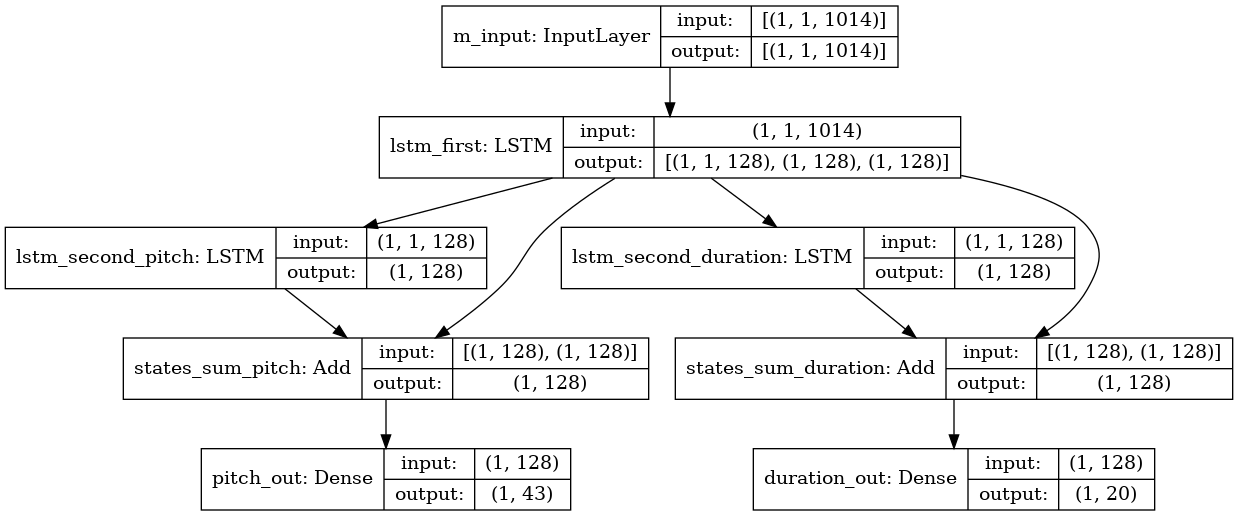

In [11]:
cum_loss=0
best_loss=float('inf')
loss_per_epoch = {"train": {"all": [], "p": [], "d": []}, "val": {"all": [], "p": [], "d": []}}
learning_rates = []

LSTM_SIZE = 128 if ARTIST != "*" else 512
LSTM_SIZE2 = 64

LEARNING_RATE = 1e-5

BATCH_SIZE = 1
batch_input_shape = (BATCH_SIZE, 1, X_train.shape[1])
num_pitches = y_train_pitches.shape[-1]
num_durations = y_train_durations.shape[-1]

# model, opt, model_name = get_stateful_lstm_multi_output(batch_input_shape, num_pitches, num_durations, LSTM_SIZE, lr=LEARNING_RATE)
# model, opt, model_name = models.get_stateful_lstm_multi_output_deeper_NEW(batch_input_shape, num_pitches, num_durations, LSTM_SIZE, LSTM_SIZE2, lr=LEARNING_RATE)
model, opt, model_name = models.get_stateful_lstm_multi_output_deeper_FIX(batch_input_shape, num_pitches, num_durations, LSTM_SIZE, LSTM_SIZE2, lr=LEARNING_RATE)
last_ep = 0 

model_name += f"_{ARTIST}"
model_name += ".FIX"
model_dir = os.path.join(PATH, "models", MODE, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

print(model_dir)

from keras.utils import plot_model
plot_model(model, os.path.join(model_dir, f"{model_name}.png"), show_shapes=True)

In [12]:
with open(os.path.join(model_dir, model_name + "_model.txt"),'w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m_input (InputLayer)            [(1, 1, 1014)]       0                                            
__________________________________________________________________________________________________
lstm_first (LSTM)               [(1, 1, 128), (1, 12 585216      m_input[0][0]                    
__________________________________________________________________________________________________
lstm_second_pitch (LSTM)        (1, 128)             131584      lstm_first[0][0]                 
__________________________________________________________________________________________________
lstm_second_duration (LSTM)     (1, 128)             131584      lstm_first[0][0]                 
_______________________________________________________________________________________

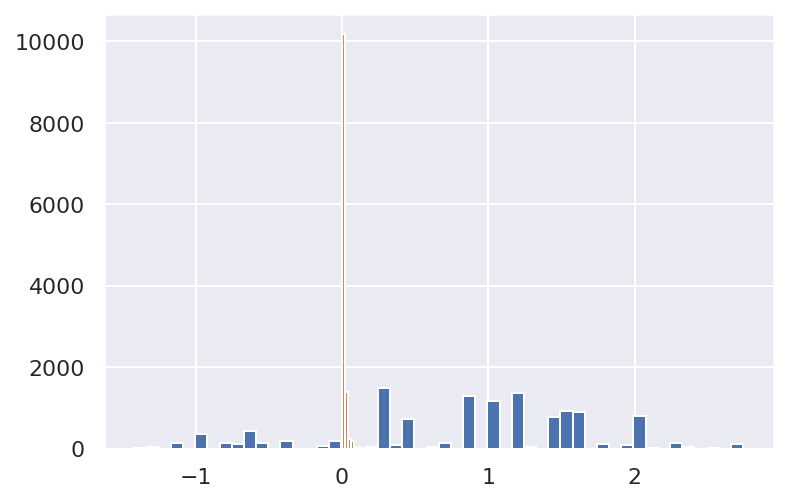

In [13]:
import matplotlib.pyplot as plt

select_feature = 0
_ = plt.hist(X_train_reshaped[:, 0, select_feature], bins=50)

select_feature = 600
_ = plt.hist(X_train_reshaped[:, 0, select_feature], bins=50)

In [14]:
model_params = {
    "artist": ARTIST,
    "rep": REP,
    "notes_window": NOTES_WINDOW,
    "chords_window": CHORDS_WINDOW,
    "pitches_per_chord": PITCHES_PER_CHORD, 
    "min_freq": MIN_FREQ,
    "unknown_tag": UNKNOWN,
    "train_split_train": train_idx_list,
    "train_split_validation": validation_idx_list,
    "train_select": TRAIN_SELECT,
    "test_select": TEST_SELECT,
    "most_common_pitches": Counter(y_train_raw_pitches).most_common(10),
    "most_common_durations": Counter(y_train_raw_durations).most_common(10),
    "mode": MODE,
    "batch_size": BATCH_SIZE,
    "batch_input_shape": batch_input_shape,
    "num_pitches": num_pitches,
    "num_durations": num_durations,
    "token_to_id_pitches": token_to_id_pitches,
    "token_to_id_durations": token_to_id_durations
}

with open(os.path.join(model_dir, "model_config.json"),'w') as fh:
    json.dump(model_params, fh)

In [16]:
# OPTIONAL: LOAD PREVIOUS RESULTS

try:
    with open(os.path.join(model_dir, "loss.json"), "r") as handle:
        loss_per_epoch = json.load(handle)
except:
    loss_per_epoch = {
        "train": {
            "all": [],
            "p": [],
            "d": []
        },
        "val": {
            "all": [],
            "p": [],
            "d": []
        }
    }
    
# # TRIM [optional]
# # TRIM=250
# # if TRIM:
# #     for t in loss_per_epoch:
# #         for tt in loss_per_epoch[t]:
# #             loss_per_epoch[t][tt] = loss_per_epoch[t][tt][:TRIM]

# # model.load_weights(os.path.join(model_dir, f'weights_{len(loss_per_epoch["train"]["all"])}.hdf5'))

last_ep = len(loss_per_epoch["train"]["all"])
try:
    model.load_weights(os.path.join(model_dir, f'weights-TMP_e{last_ep}.hdf5'))
except Exception as ex:
    print(ex)
    try:
        model.load_weights(os.path.join(model_dir, f'weights-latest.hdf5'))
        print("Loaded latest weights")
    except Exception as ex:
        print("! No model load")
        
len(loss_per_epoch["train"]["all"])

Unable to open file (unable to open file: name = 'storage/models/embeddings/LSTM-NEW-128-128_zun.FIX/weights-TMP_e347.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Loaded latest weights


347

In [17]:
min_l = float('inf')
max_l = float('-inf')

lengths = []
for i, s_idx in enumerate(train_idx_list):
    first, last, indices_cache = data_utils.extract_first_last_by_song_idx(s_idx, row_to_song_idx_train, indices_cache=indices_cache)
    if last == first:
        continue
    min_l = min(min_l, last-first)
    max_l = max(max_l, last-first)
    lengths.append(last-first)

print(min_l, max_l)

1 236


In [18]:
def batch_pad(sample_song, sample_y_p, sample_y_d, batch_size=32):
    ss = sample_song.copy()
    syp = sample_y_p.copy()
    syd = sample_y_d.copy()
    
    pad = batch_size - (ss.shape[0] % batch_size)
    ss = np.concatenate(
        (
            ss, 
            np.zeros(shape=(pad, 1, ss.shape[-1]))
        )
    )

    pad_onehot = np.zeros(shape=(pad, syp.shape[-1]))
    pad_onehot[-1] = 1.0
    syp = np.concatenate((syp, pad_onehot))

    pad_onehot = np.zeros(shape=(pad, syd.shape[-1]))
    pad_onehot[-1] = 1.0
    syd = np.concatenate((syd, pad_onehot))
    
    return ss, syp, syd

In [20]:
BATCH_SIZE

1

In [ ]:
from keras import backend as K
import random

EPOCHS=3000
SONGS_STEP=50

LRS = [1e-5] * 1000
EPOCHS = len(LRS)

train_size, val_size = len(train_idx_list), len(validation_idx_list)
print("# TRAIN songs:", train_size)
print("# VALIDATION songs:", val_size)

for e in range(last_ep, EPOCHS):
    print(f"\n______ EPOCH {e} _______ \n")
    random.shuffle(train_idx_list)
    K.set_value(model.optimizer.learning_rate, LRS[e])

    learning_rates.append(LRS[e])
    if SONGS_STEP:
        loss_per_epoch[f"tmp_e{e+1}"] = {"all": [], "p": [], "d": []}
        loss_per_epoch["songs_step"] = SONGS_STEP

    print("\n---- TRAIN ----")
    train_loss, train_loss_p, train_loss_d = 0.0, 0.0, 0.0
    for i, s_idx in enumerate(train_idx_list):
        first, last, indices_cache = data_utils.extract_first_last_by_song_idx(s_idx, row_to_song_idx_train, indices_cache=indices_cache)
        if last - first < BATCH_SIZE/4:
            continue
        
        sample_song = X_train_reshaped[first:last+1, :, :]
        sample_y_p = y_train_pitches[first:last+1]
        sample_y_d = y_train_durations[first:last+1]
#         sample_song, sample_y_p, sample_y_d = batch_pad(
#             sample_song, 
#             sample_y_p, 
#             sample_y_d, 
#             batch_size=BATCH_SIZE
#         )
        
        model.reset_states()
        hist = model.fit(
            {"m_input": sample_song},
            {"pitch_out": sample_y_p, "duration_out": sample_y_d},
            shuffle=False,
            batch_size=BATCH_SIZE,
            verbose=(1 if SONGS_STEP and (i+1) % SONGS_STEP == 0 else 0)
        )
        train_loss += hist.history['loss'][-1]
        train_loss_p += hist.history['pitch_out_loss'][-1]
        train_loss_d += hist.history['duration_out_loss'][-1]
        
        if SONGS_STEP and (i+1) % SONGS_STEP == 0:
            print("> CHECKPOINT!")
            print(i+1, ". loss so far =", train_loss / (i+1))
            loss_per_epoch[f"tmp_e{e+1}"]["all"].append(train_loss / (i+1))
            loss_per_epoch[f"tmp_e{e+1}"]["p"].append(train_loss_p / (i+1))
            loss_per_epoch[f"tmp_e{e+1}"]["d"].append(train_loss_d / (i+1))
            with open(os.path.join(model_dir, "loss.json"), "w") as handle:
                json.dump(loss_per_epoch, handle)
#             model.save(os.path.join(model_dir, f"weights-TMP_e{e+1}.hdf5"))

    train_loss /= train_size
    loss_per_epoch["train"]["all"].append(train_loss)
    loss_per_epoch["train"]["p"].append(train_loss_p / train_size)
    loss_per_epoch["train"]["d"].append(train_loss_d / train_size)
    print(loss_per_epoch["train"]["all"][-1], loss_per_epoch["train"]["p"][-1], loss_per_epoch["train"]["d"][-1])
    
    if train_loss < best_loss:
        print(f"Loss improved from {best_loss} to {train_loss}")
        best_loss = train_loss
        model.save(os.path.join(model_dir, "weights-best.hdf5"))
        
    # SAVE LOSS
    with open(os.path.join(model_dir, "loss.json"), "w") as handle:
        json.dump(loss_per_epoch, handle)
        model.save(os.path.join(model_dir, "weights-latest.hdf5"))
        
    print("\n---- VALIDATION ----")
    validation_loss, validation_loss_p, validation_loss_d = 0.0, 0.0, 0.0
    for i, s_idx in enumerate(validation_idx_list):
        first, last, indices_cache = data_utils.extract_first_last_by_song_idx(s_idx, row_to_song_idx_train, indices_cache=indices_cache)
        if last - first < BATCH_SIZE/4:
            continue
            
        sample_song = X_train_reshaped[first:last+1, :, :]
        sample_y_p = y_train_pitches[first:last+1]
        sample_y_d = y_train_durations[first:last+1]
#         sample_song, sample_y_p, sample_y_d = batch_pad(
#             sample_song, 
#             sample_y_p, 
#             sample_y_d, 
#             batch_size=BATCH_SIZE
#         )

        model.reset_states()
        loss, loss_p, loss_d = model.evaluate(
            {"m_input": sample_song},
            {"pitch_out": sample_y_p, "duration_out": sample_y_d},
            batch_size=BATCH_SIZE,
            verbose=0
        )
        validation_loss += loss
        validation_loss_p += loss_p
        validation_loss_d += loss_d
        
    loss_per_epoch["val"]["all"].append(validation_loss / val_size)
    loss_per_epoch["val"]["p"].append(validation_loss_p / val_size)
    loss_per_epoch["val"]["d"].append(validation_loss_d / val_size)
    print(loss_per_epoch["val"]["all"][-1], loss_per_epoch["val"]["p"][-1], loss_per_epoch["val"]["d"][-1])

# TRAIN songs: 198
# VALIDATION songs: 22

______ EPOCH 347 _______ 


---- TRAIN ----
47/47 [==============================] - 0s 4ms/step - loss: 5.2381 - pitch_out_loss: 2.9909 - duration_out_loss: 2.2471
> CHECKPOINT!
50 . loss so far = 5.118374147415161
42/42 [==============================] - 0s 4ms/step - loss: 5.2172 - pitch_out_loss: 2.9668 - duration_out_loss: 2.2504
> CHECKPOINT!
100 . loss so far = 5.118413019180298
27/27 [==============================] - 0s 4ms/step - loss: 5.2674 - pitch_out_loss: 2.9111 - duration_out_loss: 2.3563
> CHECKPOINT!
150 . loss so far = 5.131885159810384
5.141576384053086 2.9670676896066377 2.174508866637644
Loss improved from inf to 5.141576384053086

---- VALIDATION ----
6.3208745609630235 3.5517530983144585 2.7691219719973477

______ EPOCH 348 _______ 


---- TRAIN ----
79/79 [==============================] - 0s 4ms/step - loss: 5.0563 - pitch_out_loss: 2.9263 - duration_out_loss: 2.1300
> CHECKPOINT!
50 . loss so far = 5.168325748443603


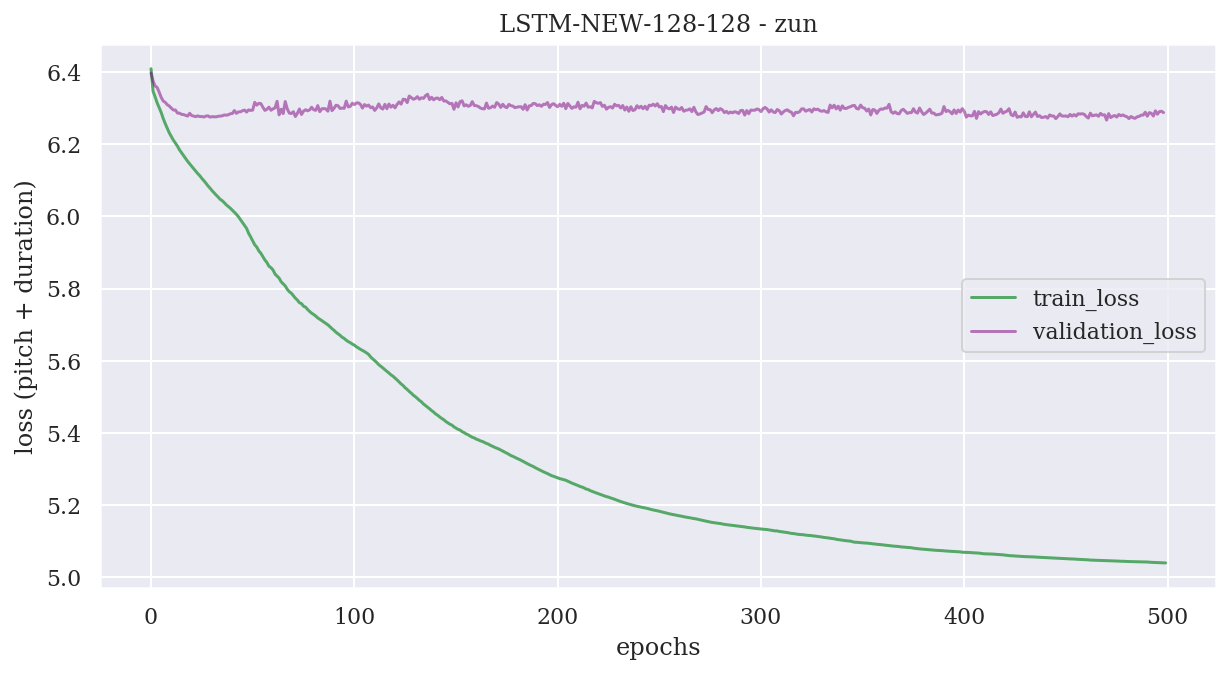

In [18]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Serif'

plt.figure(figsize=(10, 5))

plt.plot(loss_per_epoch["train"]["all"], label="train_loss", c='g')
plt.plot(loss_per_epoch["val"]["all"], label="validation_loss", c='purple', alpha=0.5)
plt.legend(loc='center right')

plt.title(f"{model_name.replace('_', ' - ')}")
plt.xlabel("epochs")
plt.ylabel("loss (pitch + duration)")

# MAKE SURE ITS SAVED!
model.save(os.path.join(model_dir, f'weights_{len(loss_per_epoch["train"]["all"])}.hdf5'))
with open(os.path.join(model_dir, "lrs.json"), "w") as handle:
    json.dump(learning_rates, handle)
with open(os.path.join(model_dir, "loss.json"), "w") as handle:
    json.dump(loss_per_epoch, handle)
    
    
plt.savefig(os.path.join(model_dir, "training.png"))
plt.show()

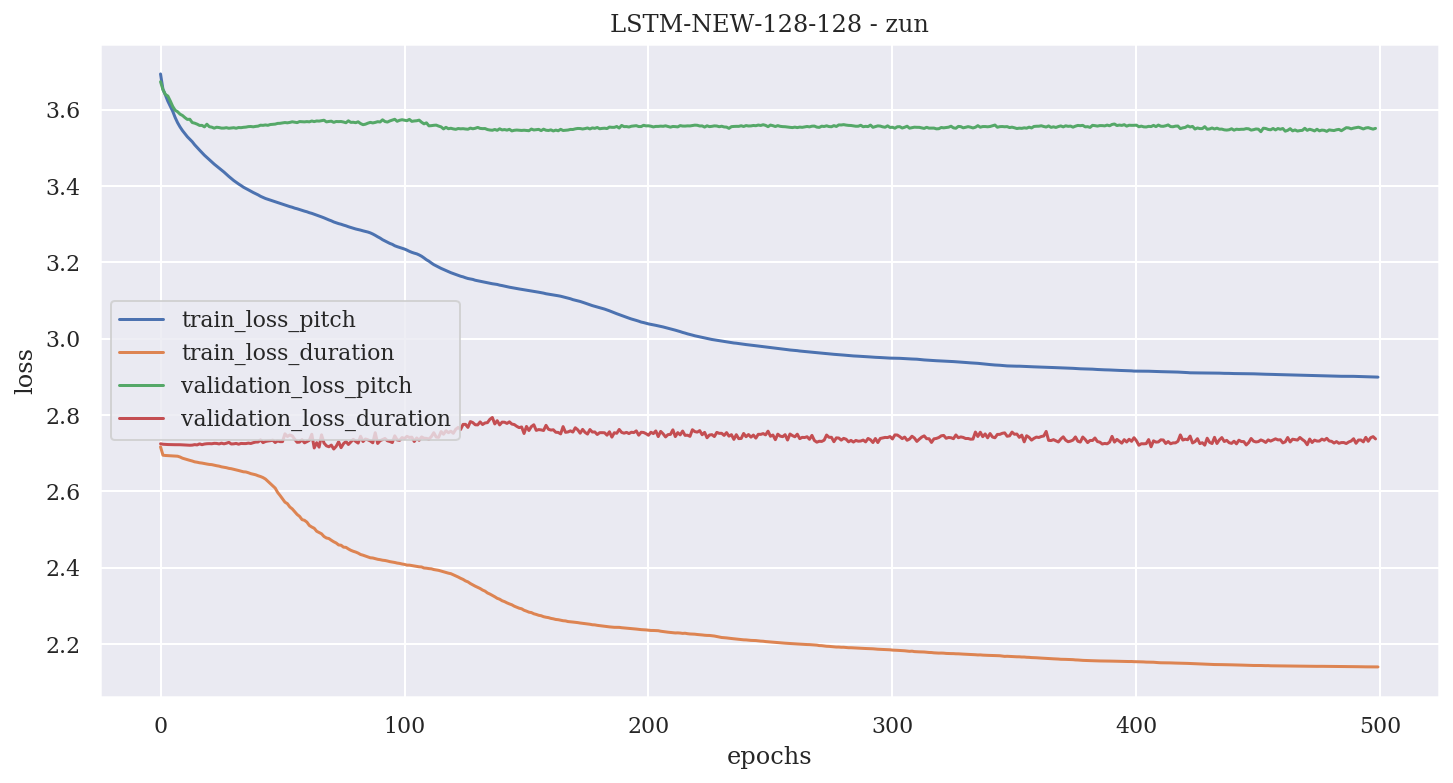

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(loss_per_epoch["train"]["p"], label="train_loss_pitch")
plt.plot(loss_per_epoch["train"]["d"], label="train_loss_duration")

plt.plot(loss_per_epoch["val"]["p"], label="validation_loss_pitch")
plt.plot(loss_per_epoch["val"]["d"], label="validation_loss_duration")

plt.legend(loc='center left')
plt.title(f"{model_name.replace('_', ' - ')}")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.savefig(os.path.join(model_dir, "training_pd.png"))
plt.show()